In [1]:
import requests
import json
import time
from datetime import date
from datetime import datetime
from helpers.history_fetcher import HistoryFetcher
import dateutil.parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdelt # pip install gdelt
import folium
import os
from tqdm import tqdm_notebook # conda install tqdm
import operator
from helpers.wiki_helpers import get_stability_for_country, make_folium_map, wiki_change_factor

import warnings
warnings.filterwarnings('ignore')

import itertools

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None
import gc

### Gather GDELT data
#### EXECUTE ONLY ON THE SERVER (memory issues)

In [ ]:
### this code is executed on the big server to obtain the results from 2011 to 2018 divided into 3 files per year
### for size.

import numpy as np
import pandas as pd
import gdelt # pip install gdelt
import gc

gd1 = gdelt.gdelt(version=1)
for i in range(11, 18):
    print('year : ', i , 1)
    results = gd1.Search(['20'+str(i)+' January 01','20'+str(i)+' May 01'],table='events')
    cols_to_keep = ['SQLDATE','ActionGeo_CountryCode','ActionGeo_Type' ]
    results = results[cols_to_keep]
    pd.to_pickle(results, 'gdelt_filtered_20'+str(i)+'_1.pckl')
    del results
    gc.collect()
    print('year : ', i , 2)
    results = gd1.Search(['20'+str(i)+' May 01','20'+str(i)+' August 01'],table='events')
    results = results[cols_to_keep]
    pd.to_pickle(results, 'gdelt_filtered_20'+str(i)+'_2.pckl')
    del results
    gc.collect()
    print('year : ', i , 3)
    if(i != 17):
        results = gd1.Search(['20'+str(i)+' August 01','20'+str(i+1)+' January 01'],table='events')
    else:
        results = gd1.Search(['20'+str(i)+' August 01','20'+str(i)+' December 01'],table='events')
    results = results[cols_to_keep]
    pd.to_pickle(results, 'gdelt_filtered_20'+str(i)+'_3.pckl')
    del results
    gc.collect()

### Process GDELT Data (aggregate) 
#### EXECUTE ONLY ON THE SERVER (memory issues)

In [ ]:
from os import listdir
from os.path import isfile, join
import gc

def process_files():
    onlyfiles = [f for f in listdir('.') if isfile(join('.', f))]
    
    grouped = pd.DataFrame()
    for i, file in enumerate(onlyfiles):
        print('processing ', file)
        gc.collect()
        try:
            data = pd.read_pickle(file)
            data['Counter'] = 1.0
            data = data[['SQLDATE','ActionGeo_CountryCode', 'ActionGeo_Type', 'Counter']]
        except:
            continue;
        grouped = grouped.append([data.groupby(['SQLDATE','ActionGeo_CountryCode', 'ActionGeo_Type']).sum()])
        pd.to_pickle(grouped, 'processed/'+str(i)+'.pckl')
        del data

### Show the gathered data

In [11]:
CAMEO_event_dic = {1:'MAKE PUBLIC STATEMENT', 
                   2:'APPEAL', 
                   3:'EXPRESS INTENT TO COOPERATE', 
                   4:'CONSULT', 
                   5:'ENGAGE IN DIPLOMATIC COOPERATION', 
                   np.NaN:'',
                   0:'UNKNOWN'}


aggregated_gdelt = pd.read_pickle('data/23.pckl')
# clean the dataframe
aggregated_gdelt.reset_index(inplace=True)
# change names
aggregated_gdelt['ActionGeo_Type'] = aggregated_gdelt['ActionGeo_Type'].map(CAMEO_event_dic)
aggregated_gdelt.sort_values('SQLDATE', inplace=True)
# take only values above 2011
aggregated_gdelt = aggregated_gdelt[aggregated_gdelt['SQLDATE'] > 20110101]
# convert to Timestamp (takes lots of time)
aggregated_gdelt['SQLDATE'] = aggregated_gdelt['SQLDATE'].apply(lambda x: str(x) )
aggregated_gdelt['SQLDATE'] = aggregated_gdelt['SQLDATE'].apply(lambda x: pd.Timestamp(x) )
pd.to_pickle(aggregated_gdelt, 'data/aggregated_gdelt.pckl')
aggregated_gdelt.head(20)

,SQLDATE,ActionGeo_CountryCode,ActionGeo_Type,Counter
148228,2011-01-02,RQ,MAKE PUBLIC STATEMENT,82.0
148190,2011-01-02,OC,UNKNOWN,1.0
148189,2011-01-02,NZ,ENGAGE IN DIPLOMATIC COOPERATION,7.0
148188,2011-01-02,NZ,CONSULT,165.0
148187,2011-01-02,NZ,MAKE PUBLIC STATEMENT,72.0
148186,2011-01-02,NZ,UNKNOWN,2.0
148185,2011-01-02,NU,CONSULT,1.0
148184,2011-01-02,NU,MAKE PUBLIC STATEMENT,6.0
148183,2011-01-02,NU,UNKNOWN,1.0
148182,2011-01-02,NS,CONSULT,2.0


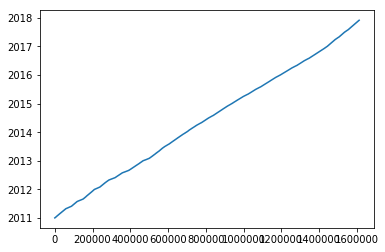

In [12]:
dates = aggregated_gdelt['SQLDATE'].values
cntr_codes = aggregated_gdelt['ActionGeo_CountryCode'].values
types = aggregated_gdelt['ActionGeo_Type'].values


plt.plot(sorted(dates))
plt.show()

In [76]:

def plot_aggregated_events(cntr_code, plot_all_in_one = False, normalize=False):
    
    activity_names = ['CONSULT', 
                      'MAKE PUBLIC STATEMENT', 
                   'APPEAL', 
                   'EXPRESS INTENT TO COOPERATE',  
                   'ENGAGE IN DIPLOMATIC COOPERATION' ]
    colors = ['b','r','g','m','y']

    plt.figure(figsize = (20,10))
    
    if(plot_all_in_one):
        values_to_plot = aggregated_gdelt[ (aggregated_gdelt['ActionGeo_CountryCode'] == cntr_code)];
        values_to_plot['ActionGeo_Type'] = 0;
        values_to_plot.groupby(['SQLDATE','ActionGeo_CountryCode', 'ActionGeo_Type']).sum()
        values_to_plot.reset_index(inplace=True)
        if(normalize):
            x = values_to_plot['SQLDATE']
            y = values_to_plot['Counter']/ values_to_plot['Counter'].mean()
        else:
            x = values_to_plot['SQLDATE']
            y = values_to_plot['Counter']
        plt.bar(x,y)
    else:
    
        for i, code in enumerate(activity_names):
            values_to_plot = aggregated_gdelt[ (aggregated_gdelt['ActionGeo_CountryCode'] == cntr_code) & 
                                              (aggregated_gdelt['ActionGeo_Type'] == code)][['SQLDATE','Counter']]

            if(normalize):
                x = values_to_plot['SQLDATE']
                y = values_to_plot['Counter']/ values_to_plot['Counter'].mean()
            else:
                x = values_to_plot['SQLDATE']
                y = values_to_plot['Counter']

            plt.bar(x,y, color=colors[i], label=code)
            plt.hold(True)
    plt.xlabel('Date')
    if(normalize):
        plt.ylabel('Normalized to mean aggregated events')
    else:
        plt.ylabel('Aggregated events')
    plt.title('Events for '+cntr_code)
    plt.show()


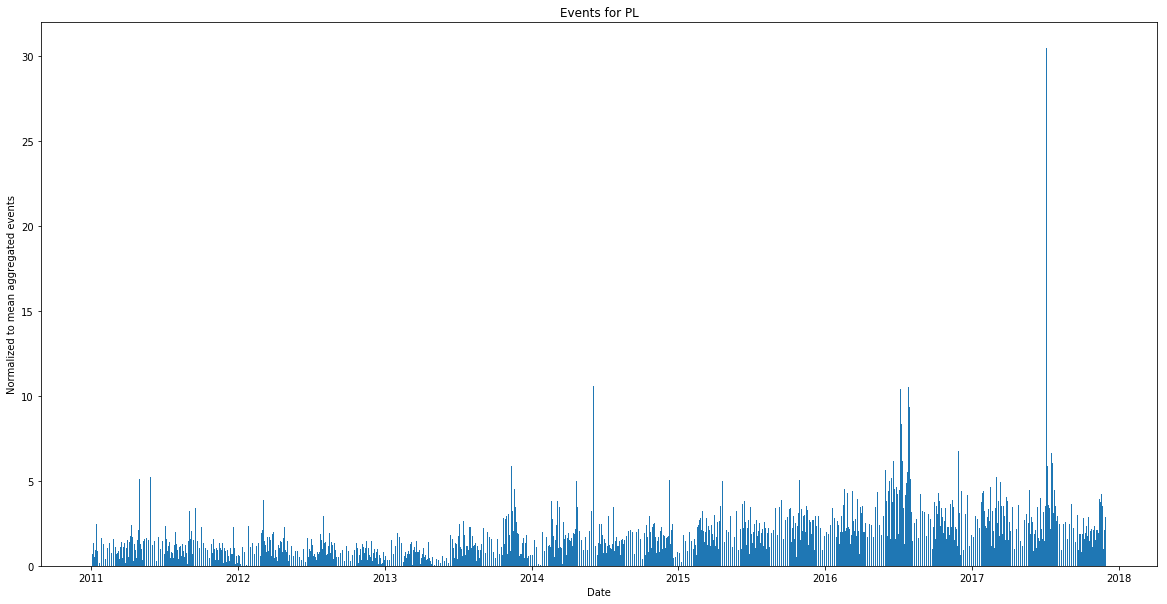

In [77]:
plot_aggregated_events('PL', plot_all_in_one=True, normalize=True)

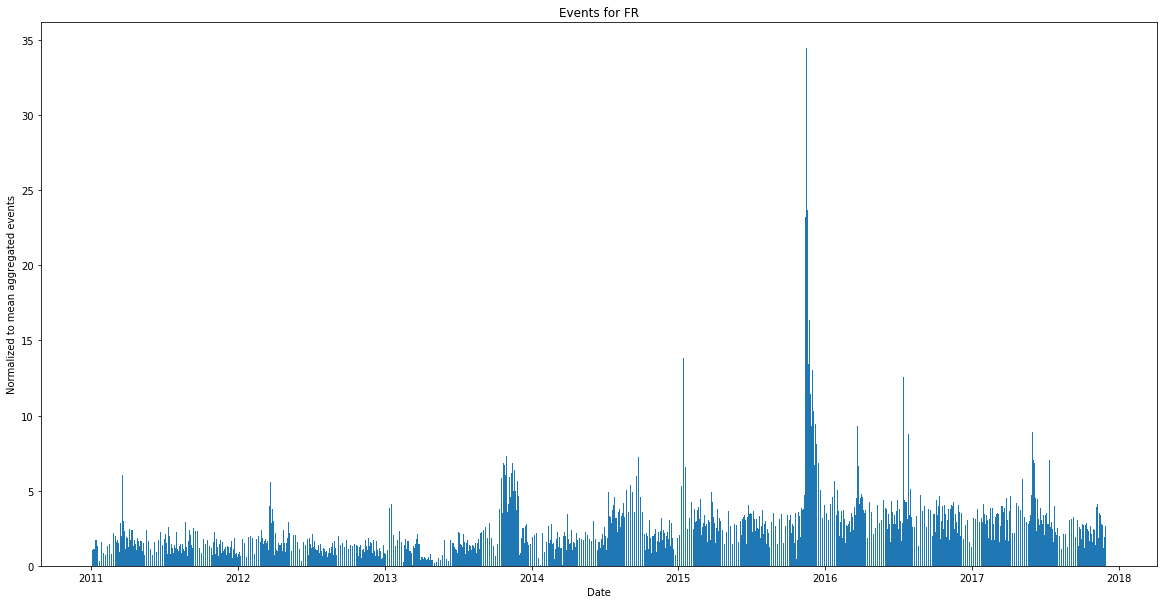

In [78]:
plot_aggregated_events('FR', plot_all_in_one=True, normalize=True)